In [1]:
import random
import matplotlib.pyplot as plt
from matplotlib import animation
import enum
import numpy as np
import copy

In [2]:
class ExtremumType(enum.Enum):
  MIN = 0
  MAX = 1

class CrossoverType(enum.Enum):
  BLX = 0 #скрещивание смешением (blend crossover – BLX)
  SBX = 1 #имитация двоичного скрещивания (simulated binary crossover – SBX)

In [3]:
#Настройка параметров
EXTREMUM_TYPE = ExtremumType.MIN
LENGTH = 2
POSITION_MAX = 50.0
POSITION_MIN = -50.0 

POPULATION_SIZE = 200
MAX_GENERATIONS = 100

CROSSOVER_TYPE = CrossoverType.BLX
P_CROSSOVER = 0.9
ALPHA_BLX_COEFFICIENT = 0.5 #коэффициент, отвечающий за ширину диапазона для выбора новых генов (При 0 имеем совпадение интервала со значениями в генах родителей. При 0.5 интервал увеличивается в 2 раза, а при 1 интервал становится больше в 4 раза. Обычно, на практике выбирают 0.5)
NU_SBX_COEFFICIENT = 20 #коэффициент, отвечающий за близость потомков к родителям (обычно выбирается 10 или 20)

P_MUTATION = 0.1
SIGMA = 5 #стандартное отклонение

USE_ELITISM = 1
HALL_OF_FAME_SIZE = 5

In [4]:
RANDOM_SEED=42
random.seed(RANDOM_SEED)

In [5]:
class Fitness():
    def __init__(self):
        self.values= -1

class Individual(list):
    def __init__(self, *args):
        super().__init__(*args)
        self.fitness = Fitness()

In [6]:
# f(x,y) = (x+2*-y+3)^2+(2*x+y-8)^2 [-100; 100]
# def fitnessFunction(individual):
#   x, y = individual
#   f1=x+2*-y+3
#   f2=2*x+y-8
#   r = f1**2+f2**2
#   return r

# f(x,y) = (X^2+y-11)^2+(x+y^2-7)^2 [-5; 5]
def fitnessFunction(individual):
  x, y = individual
  f = (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2
  return f

def individualCreator():
    return Individual([random.uniform(POSITION_MIN, POSITION_MAX) for i in range(LENGTH)])

def populationCreator(n=0):
    return list([individualCreator() for i in range(n)])

In [7]:
def clone(value):
    ind=Individual(value[:])
    ind.fitness.values=value.fitness.values
    return ind

def selTournament(population, p_len):
    favorites = []
    if USE_ELITISM == 1:
      population_length = p_len - HALL_OF_FAME_SIZE
    else:
      population_length = p_len
    for n in range(population_length) :
        i1 =i2 =i3 = 0
        while i1==i2 or i1 == i3 or i2 == i3:
            i1, i2, i3 = random.randint(0, p_len-1), random.randint(0, p_len-1), \
            random.randint(0, p_len -1)
        tournamentIndividualsList = [population[i1], population[i2], population[i3]]
        favorites.append(bestIndividual(tournamentIndividualsList)) 
    return favorites 

def bestIndividual(individuals) -> Individual:
    if EXTREMUM_TYPE == ExtremumType.MAX:
      return max(individuals, key=lambda ind: ind.fitness.values)
    elif EXTREMUM_TYPE == ExtremumType.MIN:
      return min(individuals, key=lambda ind: ind.fitness.values)

def crossover(child1, child2):
  if CROSSOVER_TYPE == CrossoverType.BLX:
    BLX(child1, child2)
  elif CROSSOVER_TYPE == CrossoverType.SBX:
    SBX(child1, child2)

def BLX(child1, child2):
  for i in range(len(child1)):
    leftBorder = child1[i]-ALPHA_BLX_COEFFICIENT*(child2[i]-child1[i])
    rightBorder = child2[i]+ALPHA_BLX_COEFFICIENT*(child2[i]-child1[i])
    if leftBorder > rightBorder:
      leftBorder, rightBorder = rightBorder, leftBorder
    child1[i] = random.uniform(leftBorder, rightBorder)
    child2[i] = random.uniform(leftBorder, rightBorder)

def SBX(child1, child2):
  for i in range(len(child1)):
    betta = 0
    u = random.randint(0, 1)
    if u <= 0.5:
      betta = (2*u)**(1/(NU_SBX_COEFFICIENT+1))
    else:
      betta = ((1/2)*(1-u))**(1/(NU_SBX_COEFFICIENT+1))
    newGenChild1 = (1/2)*((1+betta)*child1[i]+(1-betta)*child2[i])
    newGenChild2 = (1/2)*((1-betta)*child1[i]+(1+betta)*child2[i])
    child1[i] = newGenChild1
    child2[i] = newGenChild2

def mutation(mutant, indpb=1.0/LENGTH):
  for indx in range (len(mutant)):
    if random.random() < indpb:
      mutant[indx] = random.triangular(POSITION_MIN, POSITION_MAX, random.gauss(mutant[indx], SIGMA))  

In [8]:
def printStatistic():
    bestFitness = bestIndividual(population).fitness.values
    meanFitness =sum(fitnessValues)/len(population)
    bestFitnessValues.append(bestFitness)
    meanFitnessValues.append(meanFitness)
    
    print(f"Поколение {generationCounter}: Макс приспособ.= {bestFitness}, \
        Средняя приспособ.= {meanFitness}") 
    best_index=fitnessValues.index(bestFitness)
    print("Лучший индивидуум=", *population[best_index])
    if USE_ELITISM == 1:
      print("Зал славы=" , *hof)
    print("\n")

In [9]:
generationCounter = 1
hof = []
individuals_for_generations = []

In [10]:
bestFitnessValues=[]
meanFitnessValues=[]

In [11]:
population = populationCreator(n=POPULATION_SIZE) 

fitnessValues=list(map(fitnessFunction,population))
for individual, fitnessValue in zip(population, fitnessValues):
    individual.fitness.values=fitnessValue

if USE_ELITISM == 1:
      hof = []
      cloned_population = list(map(clone, population))
      if EXTREMUM_TYPE == ExtremumType.MAX:
        cloned_population.sort(key=lambda ind: ind.fitness.values, reverse=True)
      elif EXTREMUM_TYPE == ExtremumType.MIN:
        cloned_population.sort(key=lambda ind: ind.fitness.values)
      for i in range(HALL_OF_FAME_SIZE):
        hof.append(cloned_population[i])

individuals_for_generations.append(copy.deepcopy(population))

printStatistic()

Поколение 1: Макс приспособ.= 235.08497415638624,         Средняя приспособ.= 2647645.195629997
Лучший индивидуум= -2.471762190126867 4.9803593494943925
Зал славы= [-2.471762190126867, 4.9803593494943925] [-6.189991608549597, 1.7575841035590614] [-7.642137698007922, -3.297533196332502] [-4.499163266085674, -7.699251400983712] [-7.011185001016543, 7.9984781195681975]




In [12]:
while generationCounter < MAX_GENERATIONS:
    generationCounter += 1 

    favorites = selTournament(population, len(population))
    favorites = list(map(clone, favorites))
    for child1, child2 in zip(favorites[::2], favorites[1::2]):
        if random.random() < P_CROSSOVER:
            crossover(child1, child2)
                                  
    for mutant in favorites:
        if random.random() < P_MUTATION:
            mutation(mutant)

    if USE_ELITISM == 1:
      for i in range(HALL_OF_FAME_SIZE):
        favorites.append(hof[i])            

    freshFitnessValues = list(map(fitnessFunction, favorites))
    for  individual, fitnessValue in zip(favorites, freshFitnessValues):
        individual.fitness.values = fitnessValue 

    if USE_ELITISM == 1:
      hof = []
      cloned_population = list(map(clone, favorites))
      if EXTREMUM_TYPE == ExtremumType.MAX:
        cloned_population.sort(key=lambda ind: ind.fitness.values, reverse=True)
      elif EXTREMUM_TYPE == ExtremumType.MIN:
        cloned_population.sort(key=lambda ind: ind.fitness.values)
      for i in range(HALL_OF_FAME_SIZE):
        hof.append(cloned_population[i])

    individuals_for_generations.append(copy.deepcopy(favorites))

    population[:] = favorites
    fitnessValues = [ind.fitness.values for ind in population]
    
    printStatistic()

Поколение 2: Макс приспособ.= 21.621690570291573,         Средняя приспособ.= 1462998.8761998226
Лучший индивидуум= 2.0087886452428947 2.5237263448906617
Зал славы= [2.0087886452428947, 2.5237263448906617] [-1.3991301955217619, -3.9491354487245864] [-2.250644657599364, 4.9285462878026465] [-2.471762190126867, 4.9803593494943925] [-4.755296866779695, 4.071377187097051]


Поколение 3: Макс приспособ.= 5.657149566179127,         Средняя приспособ.= 160250.57740216132
Лучший индивидуум= -2.595948756430591 2.781016770651881
Зал славы= [-2.595948756430591, 2.781016770651881] [-4.074079741148395, -3.0231999552588125] [-3.107620227223295, -3.1094571765998857] [2.0087886452428947, 2.5237263448906617] [-3.7933670978443494, 3.005196156990717]


Поколение 4: Макс приспособ.= 5.657149566179127,         Средняя приспособ.= 23844.713058123885
Лучший индивидуум= -2.595948756430591 2.781016770651881
Зал славы= [-2.595948756430591, 2.781016770651881] [-3.855776770826527, -2.8931400291412848] [-3.9838640

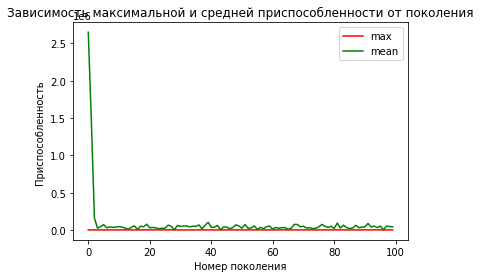

In [13]:
plt.plot(bestFitnessValues, color='red', label='max')
plt.plot(meanFitnessValues, color='green', label='mean')
plt.xlabel('Номер поколения')
plt.ylabel('Приспособленность ')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
plt.legend()
plt.show()

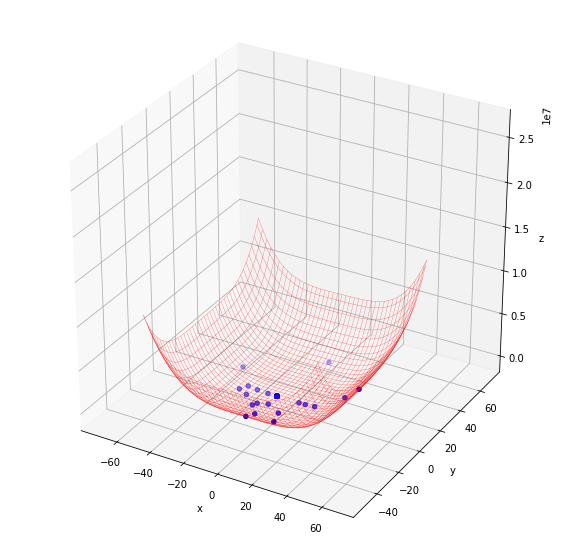

In [14]:
# Подготовка графика
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
x = np.linspace(POSITION_MIN, POSITION_MAX, 80)
y = np.linspace(POSITION_MIN, POSITION_MAX, 80)
X, Y = np.meshgrid(x, y)
Z = fitnessFunction([X,Y])
ax.plot_wireframe(X, Y, Z, color='r', linewidth=0.2)

# Хранит изображение
images = []

# Добавление изображения для каждого поколения
for t in range(len(individuals_for_generations)):
  image = ax.scatter3D(
                         [individuals_for_generations[t][n][0] for n in range(POPULATION_SIZE)],
                         [individuals_for_generations[t][n][1] for n in range(POPULATION_SIZE)],
                         [individuals_for_generations[t][n].fitness.values for n in range(POPULATION_SIZE)], c='b') 
  images.append([image])
# Сгенерировать изображение и сохранить
animated_image = animation.ArtistAnimation(fig, # фигура, где отображается анимация
    images,              # кадры
    interval=70,        # задержка между кадрами в мс
    blit=True,          # использовать ли двойную буферизацию
    repeat=True)       # зацикливать ли анимацию
# Потом нужно отдельно вызвать эту гиф, чтобы показать анимацию
animated_image.save('/content/pso_simple.gif', writer='pillow') 

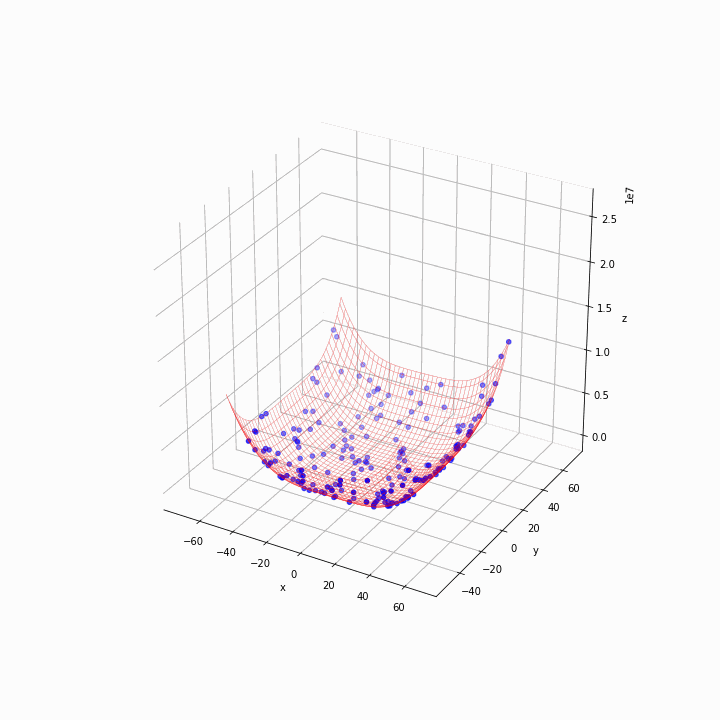

In [15]:
from IPython.display import Image

fname = '/content/pso_simple.gif'
Image(open(fname, 'rb').read())